%pip install datasets
%pip install transformers
%pip install sentencepiece
%pip install diffusers --upgrade
%pip install invisible_watermark accelerate safetensors
%pip install accelerate
%pip install jiwer
%pip install evaluate --upgrade
%pip install wandb --upgrade

In [1]:
import pandas as pd
import datasets
from PIL import Image, ImageFile
Image.LOAD_TRUNCATED_IMAGES = True
ImageFile.LOAD_TRUNCATED_IMAGES = True
import torch
import torch.nn as nn
from transformers import AutoProcessor
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Loading

1. **Loading Data:**
    - The code first checks if a variable named `data` is not already defined in the local namespace. If it's not defined, it loads a CSV file named 'described_dataset_label.csv' located one directory above the current directory.
    - The data is read using Pandas `read_csv()` function, specifying the file path, delimiter (`sep` parameter) as '\t' (tab-separated), and encoding as 'latin-1'.
    - It then selects the first 20,000 rows of the dataset using `.iloc[:20000]`.
    - The column names are then renamed for consistency using `.rename()` method.
    - Finally, it selects only specific columns ('image', 'author', 'title', 'style') using indexing.

2. **Data Preprocessing:**
    - It prefixes the 'image' column values with a dot ('.') using list comprehension and assigns the result back to the 'image' column.

3. **Label Encoding:**
    - The code checks if variables `labels_auth` and `labels_sty` are not already defined in the local namespace.
    - If not defined, it extracts unique values from the 'author' and 'style' columns of the `data` DataFrame and stores them in `labels_auth` and `labels_sty`, respectively.
    - It then creates dictionaries `label2id_auth` and `id2label_auth` to map authors to unique IDs and vice versa.
    - Similarly, it creates dictionaries `label2id_sty` and `id2label_sty` to map styles to unique IDs and vice versa.

## Reasoning:
- **Loading Data:** 
    - The code loads a dataset from a CSV file, presumably containing information about images such as their authors, titles, and styles.
    - It selects only a subset of the dataset (first 20,000 rows) for faster processing or due to memory constraints.
    - Renaming and selecting specific columns ensure consistency and relevance to the task.

- **Data Preprocessing:**
    - The prefixing of the 'image' column values with a dot seems to be a formatting step, possibly to ensure compatibility with file paths.

- **Label Encoding:**
    - Encoding labels into numerical IDs is a common preprocessing step in machine learning tasks. It converts categorical data into a format that machine learning algorithms can understand.
    - These mappings (`label2id_auth`, `id2label_auth`, `label2id_sty`, `id2label_sty`) facilitate the conversion between labels and their corresponding numerical IDs during training and prediction stages.


In [2]:
import json


if 'data' not in locals():
    data = pd.read_csv('../described_dataset_label.csv',sep='\t',encoding='utf-8')
    data = data[:20000]
    data = data.rename(columns={'FILE':'image','AUTHOR':'author', 'TITLE': 'title', 'TECHNIQUE':'style'})
    data = data[['image','author','title','style']]
    data['image'] = [f'.{x}' for x in data['image']]
    data['author'] = [x.lower() for x in data['author']]
    data['style'] = [x.split(',')[0].lower() for x in data['style']]
if 'labels_auth' not in locals():
    with open('../label_author.json', 'r') as f:
        labels_author = json.load(f)
label2id_auth, id2label_auth = dict(), dict()
for i, label in labels_author.items():
    id2label_auth[i]=label
    label2id_auth[label]=i
if 'labels_sty' not in locals():
    labels_sty = data['style'].unique()
label2id_sty, id2label_sty = dict(), dict()
for i, label in enumerate(labels_sty):
    label2id_sty[label]=i
    id2label_sty[i]=label

In [4]:
print(label2id_auth)
print(labels_author)
print(len(labels_author))

{'aachen, hans von': '0', 'aagaard, carl frederik': '1', 'abadia, juan de la': '2', 'abaquesne, masséot': '3', "abbate, niccolò dell'": '4', 'abbati, giuseppe': '5', 'abbatini, guido ubaldo': '6', 'abeele, pieter van': '7', 'abildgaard, nicolai': '8', 'abondio, antonio': '9', 'achenbach, oswald': '10', 'adam, albrecht': '11', 'adam, lambert-sigisbert': '12', 'adam, nicolas-sébastien': '13', 'adam, robert': '14', 'adam-salomon, antoine-samuel': '15', 'ademollo, luigi': '16', 'adler, salomon': '17', 'adolphi, christoffel': '18', 'adriaenssen, alexander': '19', 'adriano fiorentino': '20', 'aelst, willem van': '21', 'aenvanck, theodoor': '22', 'aert van ort': '23', 'aertsen, pieter': '24', 'agasse, jacques-laurent': '25', 'agnolo di polo': '26', 'agnolo di ventura': '27', 'agostino di duccio': '28', 'agostino di giovanni': '29', "agrate, gian francesco ferrari d'": '30', 'aivazovsky, ivan konstantinovich': '31', 'aken, joseph van': '32', 'akotantos, angelos': '33', "alba, macrino d'": '34'

1. **Label Mapping:**
    - It utilizes the `map()` function in Pandas to replace each unique label in the 'author' and 'style' columns with their corresponding numerical IDs stored in the `label2id_auth` and `label2id_sty` dictionaries, respectively.
    - This transformation effectively converts categorical labels into numerical representations, facilitating machine learning model training.

Mapping categorical labels to numerical IDs is essential for many machine learning algorithms, as they typically require numerical input. By replacing categorical labels with numerical IDs, the data becomes suitable for training predictive models.

In [5]:
data['author'] = data['author'].map(label2id_auth)
data['style'] = data['style'].map(label2id_sty)
print(data.columns)

Index(['image', 'author', 'title', 'style'], dtype='object')


Finally we create a Dataset from the processed data while also casting the image data to a PIL Image.

In [6]:
dataset = datasets.Dataset.from_pandas(data).cast_column('image',datasets.Image())
print(dataset)

Dataset({
    features: ['image', 'author', 'title', 'style'],
    num_rows: 20000
})


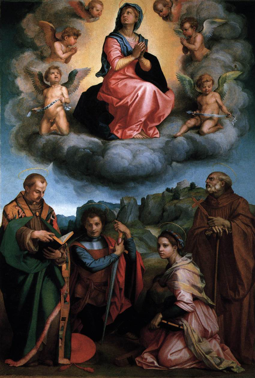

Author: andrea del sarto
Technique: oil on wood


In [7]:
sample = dataset[500]

image = sample['image']
height,width = image.size
display(image.resize((int(0.3*height),int(0.3*width))))
author = id2label_auth[sample['author']]
technique = id2label_sty[sample['style']]
print(f'Author: {author}')
print(f'Technique: {technique}')

1. **Checkpoint Initialization (`checkpoint_clas`):**
    - The variable `checkpoint_clas` is assigned the string 'google/vit-base-patch16-224-in21k'.
    - This string likely serves as a reference to the specific pre-trained model checkpoint. 
    - The mentioned model, 'vit-base-patch16-224', is a Vision Transformer model with a patch size of 16x16 and input image size of 224x224. The 'in21k' part indicates that the model has been pre-trained on an ImageNet-21k dataset, which includes 21,000 classes.

2. **Processor Initialization (`processor_clas`):**
    - The `AutoProcessor.from_pretrained()` method is used to initialize a processor for the specified pre-trained model.
    - The `AutoProcessor` class automatically selects the appropriate processor based on the provided checkpoint string.
    - The initialized processor is capable of handling various preprocessing tasks required for input data, such as tokenization, resizing, and normalization, to make it compatible with the model's architecture.


In [8]:
checkpoint_clas = 'google/vit-base-patch16-224-in21k'
processor_clas = AutoProcessor.from_pretrained(checkpoint_clas)

1. **Normalization:**
    - The code initializes a normalization transform (`normalize`) using the `Normalize` class from `torchvision.transforms`. 
    - The mean and standard deviation for normalization are obtained from the `processor_clas` object, which likely contains parameters specific to the pre-trained model's preprocessing requirements.
    - `processor_clas.image_mean` and `processor_clas.image_std` are used to set the mean and standard deviation, respectively, for normalizing the input images.

2. **Image Size Determination:**
    - The variable `size` is calculated based on the dimensions specified in the `processor_clas` object.
    - If the `processor_clas.size` dictionary contains a key named "shortest_edge", the `size` is set to the value corresponding to this key. Otherwise, the `size` is set to a tuple containing the height and width specified in the `processor_clas.size` dictionary.

3. **Compose Transformations:**
    - A sequence of transformations is defined using the `Compose` class from `torchvision.transforms`. 
    - The defined transformations include:
        - `RandomResizedCrop`: This transformation performs a random crop of the input image and resizes it to the specified size. The `size` parameter is set to the determined `size`.
        - `ToTensor`: This transformation converts the image data into a PyTorch tensor.
        - `normalize`: This transformation normalizes the tensor values using the specified mean and standard deviation.

## Reasoning:
- **Normalization:**
    - Normalizing the input images ensures that the pixel values are scaled to a range suitable for the model's training, typically between 0 and 1 or -1 and 1.
    - Normalization based on the mean and standard deviation of the dataset helps in stabilizing and speeding up the training process.

- **Compose Transformations:**
    - Composing the transformations into a pipeline allows for efficient preprocessing of input images before feeding them into the neural network.
    - Random cropping followed by resizing and conversion to tensor are common preprocessing steps used in image classification tasks.

In [9]:
import torch
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

normalize = Normalize(mean=processor_clas.image_mean, std=processor_clas.image_std)

size = (
    processor_clas.size["shortest_edge"]
    if "shortest_edge" in processor_clas.size
    else (processor_clas.size["height"], processor_clas.size["width"])
)

_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

In [10]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples


# Model Initialization

We then initialize the models from both Author and Style, by passing the checkpoint, the number of classes and the encodings.

In [11]:
model_clas_auth = AutoModelForImageClassification.from_pretrained(
    checkpoint_clas,
    num_labels = len(labels_author),
    id2label = id2label_auth,
    label2id = label2id_auth,
).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
model_clas_sty = AutoModelForImageClassification.from_pretrained(
    checkpoint_clas,
    num_labels = len(labels_sty),
    id2label = id2label_sty,
    label2id = label2id_sty
).to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Final Data Preparation
For both Author and Style we create two different datasets, by removing the unwanted columns and then we split this dataset into train and test sets. We chose a test size of 0.3 as it worked better for us to have a sliglty bigger test set.

In [13]:
#Author
auth_data = dataset.remove_columns(['style','title']).rename_column('author','label')
auth_dataset = auth_data.train_test_split(test_size=0.3)
auth_dataset = auth_dataset.with_transform(transforms)

In [14]:
#Style
sty_data = dataset.remove_columns(['author','title']).rename_column('style','label')
sty_dataset = sty_data.train_test_split(test_size=0.3)
sty_dataset = sty_dataset.with_transform(transforms)

Initialize the optimizers and the loss functions for both models.

In [15]:
vit_optimizer_auth = torch.optim.AdamW(model_clas_auth.parameters(), lr=1e-5)
vit_optimizer_sty = torch.optim.AdamW(model_clas_sty.parameters(), lr=1e-5)

vit_criterion_auth = nn.CrossEntropyLoss()
vit_criterion_sty = nn.CrossEntropyLoss()

In [16]:
num_epochs_class = 50
torch.cuda.empty_cache()

In [17]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

To be able to train the models through the Trainer class of the transformer library we need metrics which are used to evaluate the model as it is training. We use the accuracy, precision, recall and f1 score as metrics for both models.

1. **Function Definition (`compute_metrics`):**
    - This function takes a `pred` parameter, presumably containing predictions made by a classification model.
    - It extracts true labels (`labels`) and predicted labels (`preds`) from the `pred` object.
    
2. **Metrics Calculation:**
    - **Accuracy:** 
        - The accuracy is calculated using the `accuracy_score` function from scikit-learn, comparing true labels (`labels`) and predicted labels (`preds`).
    - **Precision, Recall, and F1-score:** 
        - Precision, recall, and F1-score are calculated using `precision_score`, `recall_score`, and `f1_score` functions, respectively, from scikit-learn.
        - These metrics are computed with the 'weighted' averaging strategy to handle class imbalance. The `zero_division` parameter is set to 0 to handle cases where there are no true positives for a particular class, ensuring no division by zero errors.
        
3. **Return Statement:**
    - The function returns a dictionary containing the computed evaluation metrics (`accuracy`, `precision`, `recall`, `f1`).

## Reasoning:
- **Metric Selection:**
    - Accuracy, precision, recall, and F1-score are commonly used metrics for evaluating classification models.
    - Accuracy provides an overall assessment of the model's correctness.
    - Precision measures the model's ability to correctly identify positive instances out of all instances predicted as positive.
    - Recall measures the model's ability to correctly identify positive instances out of all actual positive instances.
    - F1-score is the harmonic mean of precision and recall, providing a balance between the two metrics.

- **Weighted Averaging:**
    - Using weighted averaging for precision, recall, and F1-score is suitable for handling class imbalance scenarios where some classes may have significantly more samples than others.


In [18]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    
    # Calculate accuracy
    accuracy = accuracy_score(labels, preds)

   # Calculate precision, recall, and F1-score
    precision = precision_score(labels, preds, average='weighted',zero_division=0)
    recall = recall_score(labels, preds, average='weighted',zero_division=0)
    f1 = f1_score(labels, preds, average='weighted',zero_division=0)
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

The following code initializes and trains a classification model using the Hugging Face `Trainer` interface. It also defines training arguments (`auth_training_args`) and sets up the training process.
This setup is used for both Author and Style labels.

## Code Explanation:
1. **Training Arguments Initialization (`auth_training_args`):**
    - The code initializes a `TrainingArguments` object named `auth_training_args` with various parameters required for training the classification model.
    - Key parameters include:
        - `output_dir`: Specifies the directory where model checkpoints and other outputs will be saved.
        - `evaluation_strategy`: Sets the evaluation strategy to perform evaluation at the end of each epoch.
        - `learning_rate`: Sets the initial learning rate for the optimizer.
        - `per_device_train_batch_size`: Specifies the batch size per GPU for training data.
        - `gradient_accumulation_steps`: Accumulates gradients over multiple steps to effectively increase the batch size.
        - `num_train_epochs`: Specifies the total number of training epochs.
        - `metric_for_best_model`: Specifies the metric to monitor for determining the best model during training.
        - `push_to_hub`: Specifies whether to push the trained model to the Hugging Face model hub after training.

2. **Trainer Initialization (`auth_trainer`):**
    - The code initializes a `Trainer` object named `auth_trainer` for training the classification model.
    - Key arguments passed to the `Trainer` object include:
        - `model`: Specifies the classification model (`vit_model_auth`) to be trained.
        - `args`: Specifies the training arguments (`auth_training_args`) defined earlier.
        - `data_collator`: Specifies the data collator object for batch processing.
        - `train_dataset`: Specifies the training dataset (`auth_dataset['train']`).
        - `eval_dataset`: Specifies the evaluation dataset (`auth_dataset['test']`).
        - `tokenizer`: Specifies the tokenizer object (`processor_clas`) for tokenizing input data.
        - `compute_metrics`: Specifies the function for computing evaluation metrics during training.

3. **Training Process (`auth_trainer.train()`):**
    - Initiates the training process using the `train()` method of the `Trainer` object (`auth_trainer`).
    - The model is trained for the specified number of epochs (`num_train_epochs`).
    - Training progress, evaluation metrics, and checkpoints are saved based on the parameters specified in the training arguments.

4. **Memory Management (`torch.cuda.empty_cache()`):**
    - Clears the unused memory caches on the GPU after training to free up memory resources.

## Reasoning:
- **Training Configuration:**
    - The training arguments (`auth_training_args`) define various parameters crucial for training, such as batch size, learning rate, and evaluation strategy.
    - These parameters are set based on empirical observations, best practices, and the specific requirements of the training task.

- **Trainer Setup:**
    - The `Trainer` object (`auth_trainer`) encapsulates the training process, including data loading, model training, evaluation, and checkpointing.
    - By utilizing the Hugging Face `Trainer` interface, the code simplifies the training pipeline and provides convenient access to various training functionalities.


In [21]:
def model_init(trial):
    return AutoModelForImageClassification.from_pretrained(
        checkpoint_clas,
        num_labels = len(labels_author),
        id2label = id2label_auth,
        label2id = label2id_auth
    ).to(device)


In [20]:
auth_training_args = TrainingArguments(
    output_dir="model_checkpoints/auth",
    remove_unused_columns=False,
    save_strategy="epoch",
    evaluation_strategy="epoch",
    save_total_limit=2,
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=8,
    num_train_epochs=num_epochs_class,
    warmup_ratio=0.1,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    load_best_model_at_end=True,
)



auth_trainer = Trainer(
    # model = model_clas_auth,
    model_init= model_init,
    args = auth_training_args,
    data_collator=data_collator,
    train_dataset = auth_dataset['train'],
    eval_dataset = auth_dataset['test'],
    tokenizer = processor_clas,
    compute_metrics = compute_metrics,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [21]:
#HyperParameter Search

def optuna_hp_space(trial):
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-5, 1e-4, log=True),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 1, 3),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16]),
        "gradient_accumulation_steps": trial.suggest_int("gradient_accumulation_steps", 1, 4),
        "per_device_eval_batch_size": trial.suggest_categorical("per_device_eval_batch_size", [4, 8, 16]),
        "warmup_ratio": trial.suggest_float("warmup_ratio", 0.1, 0.3),
    }

In [23]:
best_trials = auth_trainer.hyperparameter_search(n_trials=10, 
                                                 backend="optuna",
                                                 hp_space=optuna_hp_space, 
                                                 direction="maximize",)

[I 2024-04-26 15:14:23,374] A new study created in memory with name: no-name-50ed364e-b567-423d-9318-ecd3221193e6
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


eval/accuracy,▁
eval/f1,▁
eval/loss,▁
eval/precision,▁
eval/recall,▁
eval/runtime,▁
eval/samples_per_second,▁
eval/steps_per_second,▁
train/epoch,▁▄▆█
train/global_step,▁▄▆█
train/grad_norm,▁▂█


wandb: WARNING Serializing object of type dict that is 147552 bytes
wandb: WARNING Serializing object of type dict that is 147552 bytes


  0%|          | 0/10940 [00:00<?, ?it/s]

{'loss': 8.4079, 'grad_norm': 3.0198729038238525, 'learning_rate': 1.1197070770638081e-05, 'epoch': 0.09}
{'loss': 8.0987, 'grad_norm': 3.1958236694335938, 'learning_rate': 2.2394141541276163e-05, 'epoch': 0.18}
{'loss': 7.7522, 'grad_norm': 3.402017593383789, 'learning_rate': 3.196704202536491e-05, 'epoch': 0.27}
{'loss': 7.6595, 'grad_norm': 4.082635402679443, 'learning_rate': 3.0273872426563802e-05, 'epoch': 0.37}
{'loss': 7.4698, 'grad_norm': 3.9913339614868164, 'learning_rate': 2.8580702827762695e-05, 'epoch': 0.46}
{'loss': 7.3989, 'grad_norm': 4.0534539222717285, 'learning_rate': 2.688753322896159e-05, 'epoch': 0.55}
{'loss': 7.3544, 'grad_norm': 4.407337665557861, 'learning_rate': 2.519436363016048e-05, 'epoch': 0.64}
{'loss': 7.2756, 'grad_norm': 5.905407428741455, 'learning_rate': 2.350119403135937e-05, 'epoch': 0.73}
{'loss': 7.2081, 'grad_norm': 4.508745193481445, 'learning_rate': 2.1808024432558267e-05, 'epoch': 0.82}
{'loss': 7.1086, 'grad_norm': 4.776023864746094, 'learn

  0%|          | 0/1173 [00:00<?, ?it/s]

[W 2024-04-26 15:30:48,495] Trial 0 failed with parameters: {'learning_rate': 3.218038139481385e-05, 'num_train_epochs': 2, 'per_device_train_batch_size': 4, 'gradient_accumulation_steps': 1, 'per_device_eval_batch_size': 8, 'warmup_ratio': 0.13132571980767546} because of the following error: RuntimeError('CUDA error: unknown error\nCUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.\nFor debugging consider passing CUDA_LAUNCH_BLOCKING=1.\nCompile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.\n').
Traceback (most recent call last):
  File "c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\optuna\study\_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
  File "c:\Users\Fede\anaconda3\envs\tf\lib\site-packages\transformers\integrations\integration_utils.py", line 200, in _objective
    trainer.train(resume_from_checkpoint=checkpoint, trial=trial)
  File "c:\Users\Fede\anaconda3\envs\tf

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [20]:
sty_training_args = TrainingArguments(
    output_dir="model_checkpoints/sty",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=8,
    num_train_epochs=num_epochs_class,
    warmup_ratio=0.1,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)



sty_trainer = Trainer(
    model = vit_model_sty,
    args = sty_training_args,
    data_collator=data_collator,
    train_dataset = sty_dataset['train'],
    eval_dataset = sty_dataset['test'],
    tokenizer = processor_clas,
    compute_metrics = compute_metrics,
)

sty_trainer.train()
torch.cuda.empty_cache()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: rullofederico16 (fede-). Use `wandb login --relogin` to force relogin


wandb: WARNING Serializing object of type dict that is 589920 bytes
wandb: WARNING Serializing object of type dict that is 589920 bytes


  0%|          | 0/21850 [00:00<?, ?it/s]

  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 9.101889610290527, 'eval_accuracy': 0.094, 'eval_precision': 0.008836, 'eval_recall': 0.094, 'eval_f1': 0.016153564899451554, 'eval_runtime': 324.7706, 'eval_samples_per_second': 18.475, 'eval_steps_per_second': 2.309, 'epoch': 1.0}
{'loss': 9.2305, 'learning_rate': 1.1441647597254006e-05, 'epoch': 1.14}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 9.044112205505371, 'eval_accuracy': 0.11716666666666667, 'eval_precision': 0.03037208281595405, 'eval_recall': 0.11716666666666667, 'eval_f1': 0.03894141525246866, 'eval_runtime': 153.5299, 'eval_samples_per_second': 39.08, 'eval_steps_per_second': 4.885, 'epoch': 2.0}
{'loss': 8.6651, 'learning_rate': 2.2883295194508012e-05, 'epoch': 2.29}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 9.07468032836914, 'eval_accuracy': 0.13566666666666666, 'eval_precision': 0.03851517682915447, 'eval_recall': 0.13566666666666666, 'eval_f1': 0.05057270725390123, 'eval_runtime': 154.1088, 'eval_samples_per_second': 38.934, 'eval_steps_per_second': 4.867, 'epoch': 3.0}
{'loss': 8.1274, 'learning_rate': 3.432494279176202e-05, 'epoch': 3.43}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 9.0028076171875, 'eval_accuracy': 0.15483333333333332, 'eval_precision': 0.049626341315844175, 'eval_recall': 0.15483333333333332, 'eval_f1': 0.06878635978856047, 'eval_runtime': 154.5492, 'eval_samples_per_second': 38.823, 'eval_steps_per_second': 4.853, 'epoch': 4.0}
{'loss': 7.6779, 'learning_rate': 4.5766590389016025e-05, 'epoch': 4.57}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 9.0643310546875, 'eval_accuracy': 0.16616666666666666, 'eval_precision': 0.05710335320309717, 'eval_recall': 0.16616666666666666, 'eval_f1': 0.0772369330179284, 'eval_runtime': 154.5555, 'eval_samples_per_second': 38.821, 'eval_steps_per_second': 4.853, 'epoch': 5.0}
{'loss': 7.3414, 'learning_rate': 4.9199084668192224e-05, 'epoch': 5.71}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 8.918682098388672, 'eval_accuracy': 0.17516666666666666, 'eval_precision': 0.06219789432308568, 'eval_recall': 0.17516666666666666, 'eval_f1': 0.0882089269490832, 'eval_runtime': 153.9246, 'eval_samples_per_second': 38.98, 'eval_steps_per_second': 4.873, 'epoch': 6.0}
{'loss': 7.0699, 'learning_rate': 4.792779049071955e-05, 'epoch': 6.86}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 8.875309944152832, 'eval_accuracy': 0.18066666666666667, 'eval_precision': 0.07750226184914205, 'eval_recall': 0.18066666666666667, 'eval_f1': 0.10175457553208198, 'eval_runtime': 154.2582, 'eval_samples_per_second': 38.896, 'eval_steps_per_second': 4.862, 'epoch': 7.0}
{'loss': 6.8638, 'learning_rate': 4.665649631324689e-05, 'epoch': 8.0}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 8.798898696899414, 'eval_accuracy': 0.1795, 'eval_precision': 0.06626312940091622, 'eval_recall': 0.1795, 'eval_f1': 0.0927469833049963, 'eval_runtime': 154.6475, 'eval_samples_per_second': 38.798, 'eval_steps_per_second': 4.85, 'epoch': 8.0}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 8.885446548461914, 'eval_accuracy': 0.185, 'eval_precision': 0.06842499303523697, 'eval_recall': 0.185, 'eval_f1': 0.09465333136762707, 'eval_runtime': 153.7528, 'eval_samples_per_second': 39.024, 'eval_steps_per_second': 4.878, 'epoch': 9.0}
{'loss': 6.618, 'learning_rate': 4.538520213577422e-05, 'epoch': 9.14}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 8.914569854736328, 'eval_accuracy': 0.18816666666666668, 'eval_precision': 0.0848767973306329, 'eval_recall': 0.18816666666666668, 'eval_f1': 0.1080473830572677, 'eval_runtime': 153.7744, 'eval_samples_per_second': 39.018, 'eval_steps_per_second': 4.877, 'epoch': 10.0}
{'loss': 6.3921, 'learning_rate': 4.411390795830155e-05, 'epoch': 10.29}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 8.939423561096191, 'eval_accuracy': 0.19, 'eval_precision': 0.0830133222555589, 'eval_recall': 0.19, 'eval_f1': 0.10823800704884178, 'eval_runtime': 167.1773, 'eval_samples_per_second': 35.89, 'eval_steps_per_second': 4.486, 'epoch': 11.0}
{'loss': 6.1926, 'learning_rate': 4.284261378082889e-05, 'epoch': 11.43}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 8.938403129577637, 'eval_accuracy': 0.1955, 'eval_precision': 0.08900735656657473, 'eval_recall': 0.1955, 'eval_f1': 0.11501044628325871, 'eval_runtime': 160.0432, 'eval_samples_per_second': 37.49, 'eval_steps_per_second': 4.686, 'epoch': 12.0}
{'loss': 5.9812, 'learning_rate': 4.157131960335622e-05, 'epoch': 12.57}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 9.08565616607666, 'eval_accuracy': 0.198, 'eval_precision': 0.08960938207866657, 'eval_recall': 0.198, 'eval_f1': 0.11540063869853011, 'eval_runtime': 183.5977, 'eval_samples_per_second': 32.68, 'eval_steps_per_second': 4.085, 'epoch': 13.0}
{'loss': 5.7453, 'learning_rate': 4.030002542588355e-05, 'epoch': 13.71}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 9.187268257141113, 'eval_accuracy': 0.19766666666666666, 'eval_precision': 0.09571700679219095, 'eval_recall': 0.19766666666666666, 'eval_f1': 0.12054312018914262, 'eval_runtime': 184.1309, 'eval_samples_per_second': 32.586, 'eval_steps_per_second': 4.073, 'epoch': 14.0}
{'loss': 5.5422, 'learning_rate': 3.902873124841088e-05, 'epoch': 14.86}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 9.050956726074219, 'eval_accuracy': 0.19533333333333333, 'eval_precision': 0.09297919957149313, 'eval_recall': 0.19533333333333333, 'eval_f1': 0.11854063563204058, 'eval_runtime': 183.1046, 'eval_samples_per_second': 32.768, 'eval_steps_per_second': 4.096, 'epoch': 15.0}
{'loss': 5.337, 'learning_rate': 3.7757437070938216e-05, 'epoch': 16.0}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 9.065268516540527, 'eval_accuracy': 0.20016666666666666, 'eval_precision': 0.08959338861362534, 'eval_recall': 0.20016666666666666, 'eval_f1': 0.11792650897865971, 'eval_runtime': 181.4568, 'eval_samples_per_second': 33.066, 'eval_steps_per_second': 4.133, 'epoch': 16.0}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 9.436363220214844, 'eval_accuracy': 0.1985, 'eval_precision': 0.10700402428759867, 'eval_recall': 0.1985, 'eval_f1': 0.1285621175044062, 'eval_runtime': 182.8616, 'eval_samples_per_second': 32.812, 'eval_steps_per_second': 4.101, 'epoch': 17.0}
{'loss': 5.1175, 'learning_rate': 3.648614289346555e-05, 'epoch': 17.14}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 9.48413372039795, 'eval_accuracy': 0.20066666666666666, 'eval_precision': 0.10597541107766835, 'eval_recall': 0.20066666666666666, 'eval_f1': 0.12971522572526265, 'eval_runtime': 182.9124, 'eval_samples_per_second': 32.803, 'eval_steps_per_second': 4.1, 'epoch': 18.0}
{'loss': 4.9049, 'learning_rate': 3.521484871599288e-05, 'epoch': 18.29}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 9.344210624694824, 'eval_accuracy': 0.1975, 'eval_precision': 0.1070410089004496, 'eval_recall': 0.1975, 'eval_f1': 0.13103545124325455, 'eval_runtime': 182.0805, 'eval_samples_per_second': 32.952, 'eval_steps_per_second': 4.119, 'epoch': 19.0}
{'loss': 4.7008, 'learning_rate': 3.3943554538520216e-05, 'epoch': 19.43}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 9.32463264465332, 'eval_accuracy': 0.203, 'eval_precision': 0.1059865438817753, 'eval_recall': 0.203, 'eval_f1': 0.13254432911644848, 'eval_runtime': 174.5401, 'eval_samples_per_second': 34.376, 'eval_steps_per_second': 4.297, 'epoch': 20.0}
{'loss': 4.5118, 'learning_rate': 3.267226036104755e-05, 'epoch': 20.57}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 9.776747703552246, 'eval_accuracy': 0.1975, 'eval_precision': 0.10773333358446233, 'eval_recall': 0.1975, 'eval_f1': 0.13227472570633936, 'eval_runtime': 184.6749, 'eval_samples_per_second': 32.49, 'eval_steps_per_second': 4.061, 'epoch': 21.0}
{'loss': 4.3047, 'learning_rate': 3.140096618357488e-05, 'epoch': 21.71}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 9.871493339538574, 'eval_accuracy': 0.20033333333333334, 'eval_precision': 0.11125146133781585, 'eval_recall': 0.20033333333333334, 'eval_f1': 0.13537589105807998, 'eval_runtime': 506.0896, 'eval_samples_per_second': 11.856, 'eval_steps_per_second': 1.482, 'epoch': 22.0}
{'loss': 4.0968, 'learning_rate': 3.0129672006102212e-05, 'epoch': 22.86}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 9.655630111694336, 'eval_accuracy': 0.20383333333333334, 'eval_precision': 0.11738909836699617, 'eval_recall': 0.20383333333333334, 'eval_f1': 0.1408607380610728, 'eval_runtime': 696.6348, 'eval_samples_per_second': 8.613, 'eval_steps_per_second': 1.077, 'epoch': 23.0}
{'loss': 3.9164, 'learning_rate': 2.8858377828629546e-05, 'epoch': 24.0}


  0%|          | 0/750 [00:00<?, ?it/s]

{'eval_loss': 9.646126747131348, 'eval_accuracy': 0.19933333333333333, 'eval_precision': 0.11499169287511438, 'eval_recall': 0.19933333333333333, 'eval_f1': 0.13917918073155125, 'eval_runtime': 508.1222, 'eval_samples_per_second': 11.808, 'eval_steps_per_second': 1.476, 'epoch': 24.0}


RuntimeError: CUDA error: out of memory
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


Finally we evaluate the model on the test set and print the results.

In [ ]:
sample = data[89]
image = sample['image']
height,width = image.size
display(image.resize((int(0.3*height),int(0.3*width))))
author = sample['author']
style = sample['style']
print(f'Author: {id2label_auth[author]}')
print(f'Style:  {id2label_sty[style]}')

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000001AB67FC4EB0>> (for pre_run_cell), with arguments args (<ExecutionInfo object at 1ab2c73b7f0, raw_cell="sample = data[89]
image = sample['image']
height,w.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/Fede/Desktop/Art/Models_with_Trainer/ArtTest-Combined_transfer_learning_Classification.ipynb#X40sZmlsZQ%3D%3D>,),kwargs {}:


TypeError: _WandbInit._resume_backend() takes 1 positional argument but 2 were given

KeyError: 89

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x000001AB67FC4EB0>> (for post_run_cell), with arguments args (<ExecutionResult object at 1afc9b2f7c0, execution_count=28 error_before_exec=None error_in_exec=89 info=<ExecutionInfo object at 1ab2c73b7f0, raw_cell="sample = data[89]
image = sample['image']
height,w.." store_history=True silent=False shell_futures=True cell_id=vscode-notebook-cell:/c%3A/Users/Fede/Desktop/Art/Models_with_Trainer/ArtTest-Combined_transfer_learning_Classification.ipynb#X40sZmlsZQ%3D%3D> result=None>,),kwargs {}:


TypeError: _WandbInit._pause_backend() takes 1 positional argument but 2 were given

In [ ]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(checkpoint_clas)

inputs = image_processor(image, return_tensors="pt").to(device)

with torch.no_grad():
    logits_auth = model_clas_auth(**inputs).logits

In [ ]:
from transformers import AutoImageProcessor

image_processor = AutoImageProcessor.from_pretrained(checkpoint_clas)

inputs = image_processor(image, return_tensors="pt").to(device)

with torch.no_grad():
    logits_sty = model_clas_sty(**inputs).logits

In [ ]:
predicted_label_auth = logits_auth.argmax(-1).item()
predicted_label_sty = logits_sty.argmax(-1).item()
print(model_clas_auth.config.id2label[predicted_label_auth])
print(model_clas_sty.config.id2label[predicted_label_sty])